In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline


# Camera Calibration & Distortion Measuring


Load a list of camera images to calibrate the camera and use one of them as test.

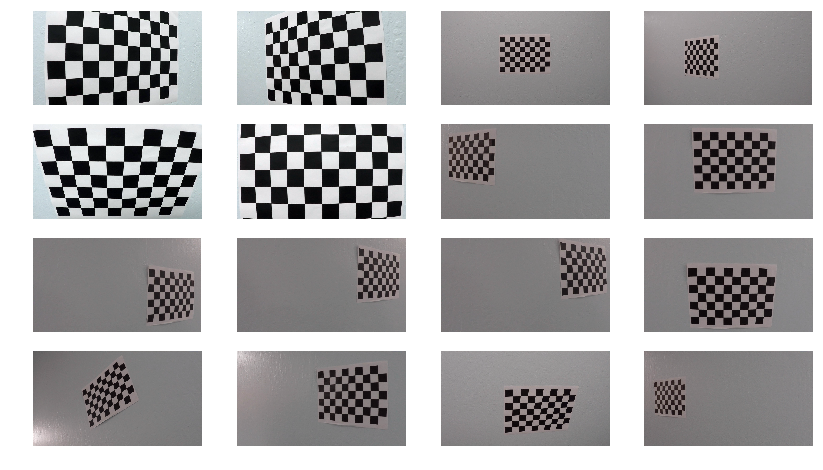

In [2]:
test_img = mpimg.imread('test_images/test3.jpg')
test_imgs = [i for i in glob.iglob('test_images/*.jpg')]
camera_images = [cv2.imread(i) for i in glob.iglob('camera_cal/calibration*.jpg')]
camera_test_images = [cv2.imread(i) for i in glob.iglob('camera_cal/test_image*.jpg')]

f, ax = plt.subplots(4, 4, figsize=(14, 8))

for i in range(4):
    for e in range(4):
        ax[i,e].imshow(camera_images[i*4 + e])
        ax[i,e].axis('off')

plt.show()

In [3]:
nx = 9
ny = 6

def camera_calibration():
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    for img, i in zip(camera_images, range(len(camera_images))):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)    
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, camera_test_images[0].shape[::-1][1:3], None, None)        
    
    return ret, mtx, dist

ret, mtx, dist = camera_calibration()

def undistort_img(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


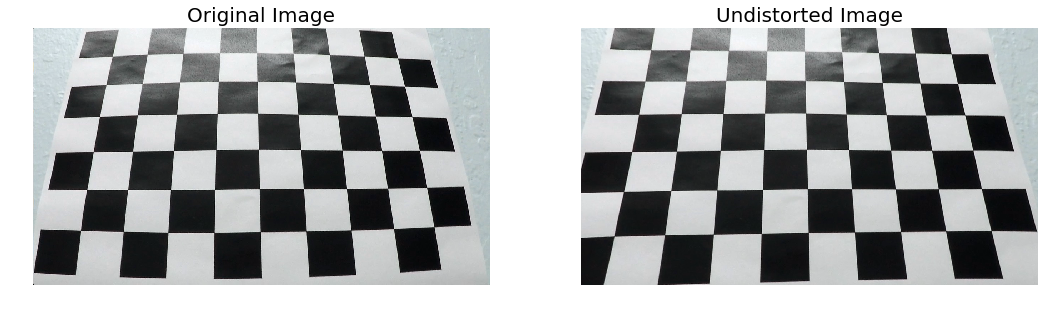

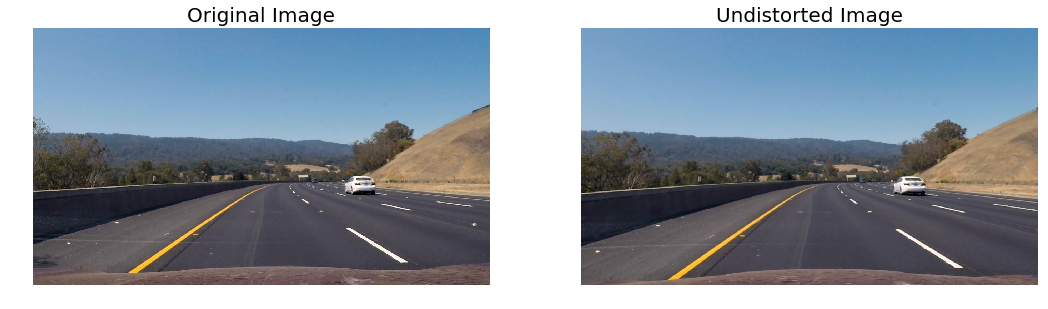

In [4]:
def test_distortion(img):
    f, ax = plt.subplots(len(camera_test_images), 2, figsize=(18, 5))
    dst = undistort_img(img)
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Original Image', fontsize=20)
    ax[1].imshow(dst)
    ax[1].axis('off')
    ax[1].set_title('Undistorted Image', fontsize=20)
    plt.show()

test_distortion(camera_test_images[0])
test_distortion(test_img)

# Gradient threshold

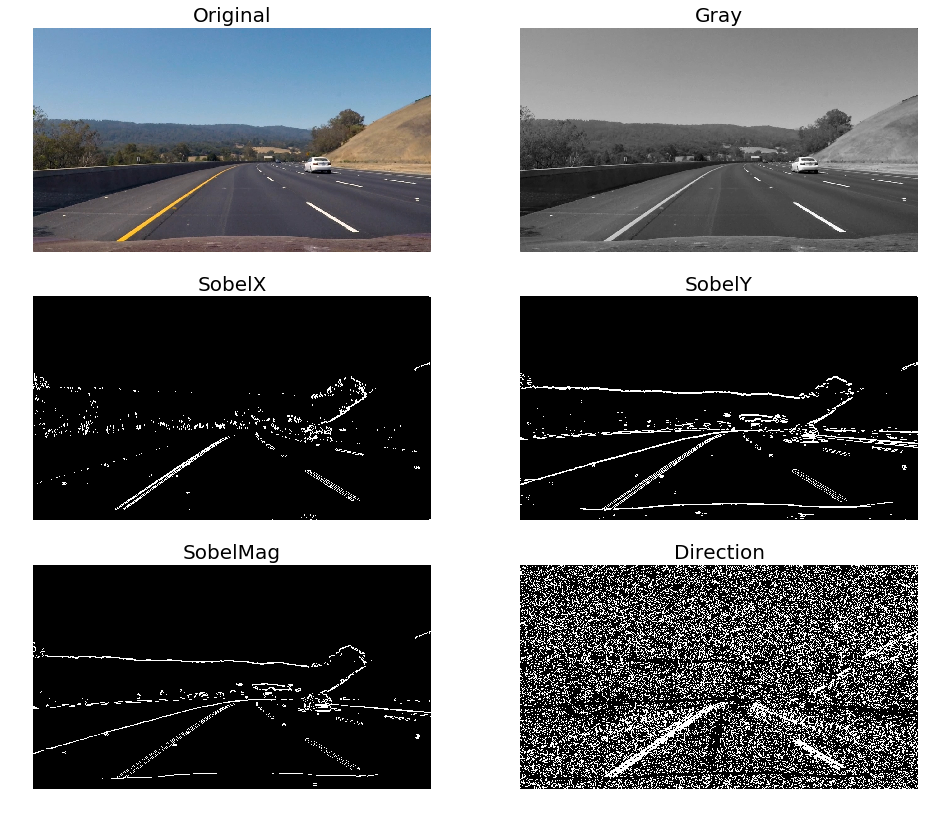

In [5]:
import matplotlib.image as mpimg

def apply_threshold(img, thresh):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    return apply_threshold(scaled_sobel, thresh)

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    return apply_threshold(gradmag, mag_thresh)

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    return apply_threshold(absgraddir, thresh)


ksize = 15
threshX = (30, 100)
threshY = (30, 100)
threshMag = (50, 100)
threashDir = (0.9, 1.3)

gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)

gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=threshX)
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=threshY)
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=threshMag)
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=threashDir)

f, ax = plt.subplots(3, 2, figsize=(16, 14))

def plt_img(ix, iy, ax, title, image):
    ax[ix,iy].imshow(image, cmap='gray')
    ax[ix,iy].axis('off')
    ax[ix, iy].set_title(title, fontsize=20)

plt_img(0,0, ax, 'Original', test_img)
plt_img(0,1, ax, 'Gray', gray)
plt_img(1,0, ax, 'SobelX', gradx)
plt_img(1,1, ax, 'SobelY', grady)
plt_img(2,0, ax, 'SobelMag', mag_binary)
plt_img(2,1, ax, 'Direction', dir_binary)
    
plt.show()


# Color Spaces



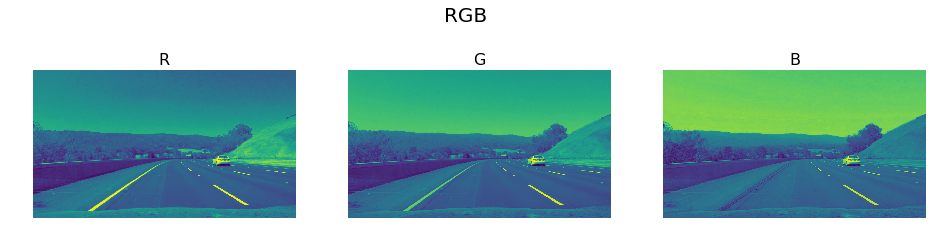

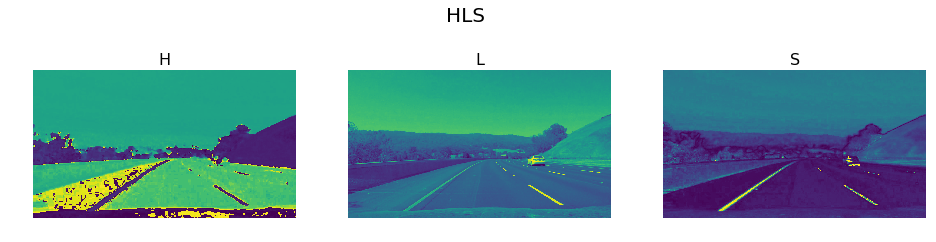

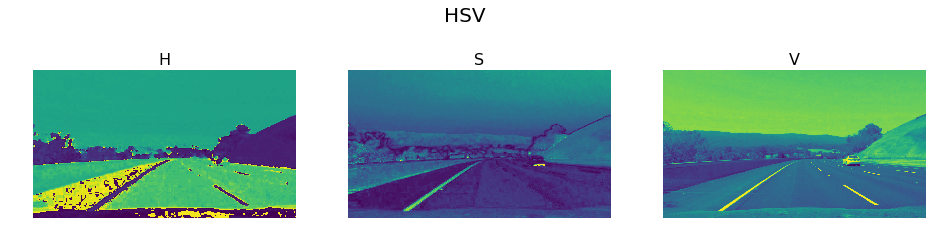

In [6]:
def color_space(title, img):
    subtitles = list(title)
    one = img[:,:,0]
    two = img[:,:,1]
    three = img[:,:,2]
    
    f, ax = plt.subplots(1, 3, figsize=(16, 4))
    
    ax[0].imshow(one)
    ax[0].axis('off')
    ax[0].set_title(subtitles[0], fontsize=16)
    
    ax[1].imshow(two)
    ax[1].axis('off')
    ax[1].set_title(subtitles[1], fontsize=16)

    ax[2].imshow(three)
    ax[2].axis('off')
    ax[2].set_title(subtitles[2], fontsize=16)
    
    plt.suptitle(title, fontsize=20)
    plt.show()

    
hls_image = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS)
hsv_image = cv2.cvtColor(test_img, cv2.COLOR_RGB2HSV)
    
color_space('RGB', test_img)
color_space('HLS', hls_image)
color_space('HSV', hsv_image)


- It's possible to use R channel of RGB
- The S channel of the HLS shows very good the lane lines
- And the V channel of HSV it's also possible to use it

Maybe just using the S channel is enough or maybe use a combination of those three selections

# Perspective Transform

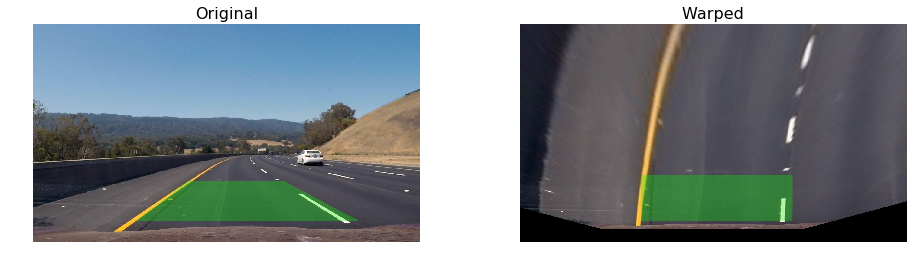

In [7]:
def warp_img(src_points, dst_points, img):
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

src_p = [ [341, 650], [1078, 650], [832, 520], [511, 520]]
dst_p = [ [400, 650], [900, 650], [900, 500], [400, 500]]

overlay = np.copy(test_img)
test_warp = np.copy(test_img)

pts = np.array(src_p, np.int32)
pts = pts.reshape((-1,1,2))
cv2.fillPoly(overlay, [pts], (0,255,0, ))

alpha = 0.3
cv2.addWeighted(overlay, alpha, test_warp, 1 - alpha, 0, test_warp)

warped = warp_img(np.float32(src_p), np.float32(dst_p), test_warp)

f, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].imshow(test_warp)
ax[0].axis('off')
ax[0].set_title('Original', fontsize=16)

ax[1].imshow(warped)
ax[1].axis('off')
ax[1].set_title('Warped', fontsize=16)
      

# Procesing Image Pipeline

The idea is to apply a set of the previous transformation to process the image that helps to most easily to detect the lane lines.

The pipeline is as follows:

- Camera calibration (just one time)
- Undistort image
- Apply a color transformation
- Apply a gradient threshold transformation using sobel
- Apply perspective transformation


Once the image pass through this pipeline is ready for the lane line detection

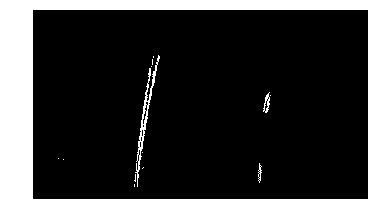

In [8]:
def img_proc_pipeline(img):
    
    # Undistort
    
    undist_img = undistort_img(img)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    
    # Color transformation to HLS and using only S channel
    
    r_channel = img[:,:,0]
    
    hls_image = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]
    
    hsv_image = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HSV)
    v_channel = hsv_image[:,:,2]
    
    # Sobel transformation using only x orientation
    ksize = 15
    threshold = (30, 100)
    sobel_binary = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=threshold)
    
    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 255
    s_channel_binary = apply_threshold(s_channel, (s_thresh_min, s_thresh_max))
    
        # Threshold color channel
    v_thresh_min = 150
    v_thresh_max = 255
    v_channel_binary = apply_threshold(v_channel, (v_thresh_min, v_thresh_max))
    
    v_thresh_min = 150
    v_thresh_max = 255
    v_channel_binary = apply_threshold(v_channel, (v_thresh_min, v_thresh_max))
    
    # Combine color and gradient
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(sobel_binary == 1) & ((s_channel_binary == 1) | (v_channel_binary == 1))] = 1

    # Perspective transformation
    
    warped = warp_img(np.float32(src_p), np.float32(dst_p), combined_binary)
    
    return warped

    
proccesed_img = img_proc_pipeline(test_img)

plt.imshow(proccesed_img, cmap='gray')
plt.axis('off')
plt.show()
    

# Finding Lines

After image pre-procesing comes the line detection

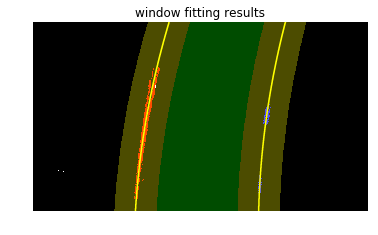

In [32]:


# Read in a thresholded image
warped = proccesed_img
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 80 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = [] 
    window = np.ones(window_width) 
        
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    window_centroids.append((l_center,r_center))
    
    for level in range(1,(int)(image.shape[0]/window_height)):
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        
        conv_signal = np.convolve(window, image_layer)
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        if np.sum(conv_signal[l_min_index:l_max_index]) != 0:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        if np.sum(conv_signal[r_min_index:r_max_index]) != 0:
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        window_centroids.append((l_center,r_center))

    return window_centroids


def find_lines(warped, window_centroids):
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)

        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    l_points_ind = np.where((l_points == 255) & (warped == 1) )
    r_points_ind = np.where((r_points == 255) & (warped == 1))
    
    if l_points_ind[0].size == 0 or r_points_ind[0].size == 0:
        return None, None, None, None, None

    left_fit = np.polyfit(l_points_ind[0], l_points_ind[1], 2)
    right_fit = np.polyfit(r_points_ind[0], r_points_ind[1], 2)
    
    output = np.dstack((warped, warped, warped))*255
    output[l_points_ind[0], l_points_ind[1]] = [255, 0, 0]
    output[r_points_ind[0], r_points_ind[1]] = [0, 0, 255]

    ploty = np.int32(np.linspace(0, output.shape[0]-1, output.shape[0] ))
    left_fitx = np.int32(left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2])
    right_fitx = np.int32(right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2])
        
    return l_points_ind, r_points_ind, left_fitx, right_fitx, ploty


def draw_fitting_results(warped, l_points_ind, r_points_ind, left_fitx, right_fitx ):
    output = np.dstack((warped, warped, warped))*255
    output[l_points_ind[0], l_points_ind[1]] = [255, 0, 0]
    output[r_points_ind[0], r_points_ind[1]] = [0, 0, 255]
    window_img = np.zeros_like(output)
    ploty = np.int32(np.linspace(0, output.shape[0]-1, output.shape[0] ))

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))

    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    center_windows1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    center_windows2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    center_pts = np.hstack((center_windows1, center_windows2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([center_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,255, 0))
    result = cv2.addWeighted(output, 1, window_img, 0.3, 0)
    
    # Display the final results
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.title('window fitting results')
    plt.axis('off')
    plt.show()
    
window_centroids = find_window_centroids(warped, window_width, window_height, margin)
l_points_ind, r_points_ind, left_fitx, right_fitx, ploty = find_lines(warped, window_centroids)
draw_fitting_results(warped, l_points_ind, r_points_ind, left_fitx, right_fitx)

In [10]:
# FIX make sure to add logic so is not necesary to calculate all the convolutions all the times

# Unwarp

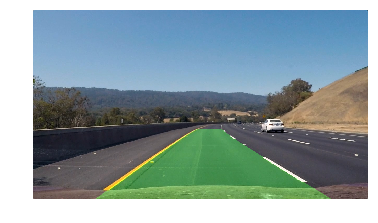

In [18]:
def unwarp(img, warped, ploty, left_fitx,  right_fitx):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = warp_img(np.float32(dst_p), np.float32(src_p), color_warp)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    #newwarp = cv2.warpPerspective(color_warp, Minv, (test_img.shape[1], test_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

result = unwarp(test_img, warped, ploty, left_fitx,  right_fitx)
plt.imshow(result)
plt.axis('off')
plt.show()


# Process Test images

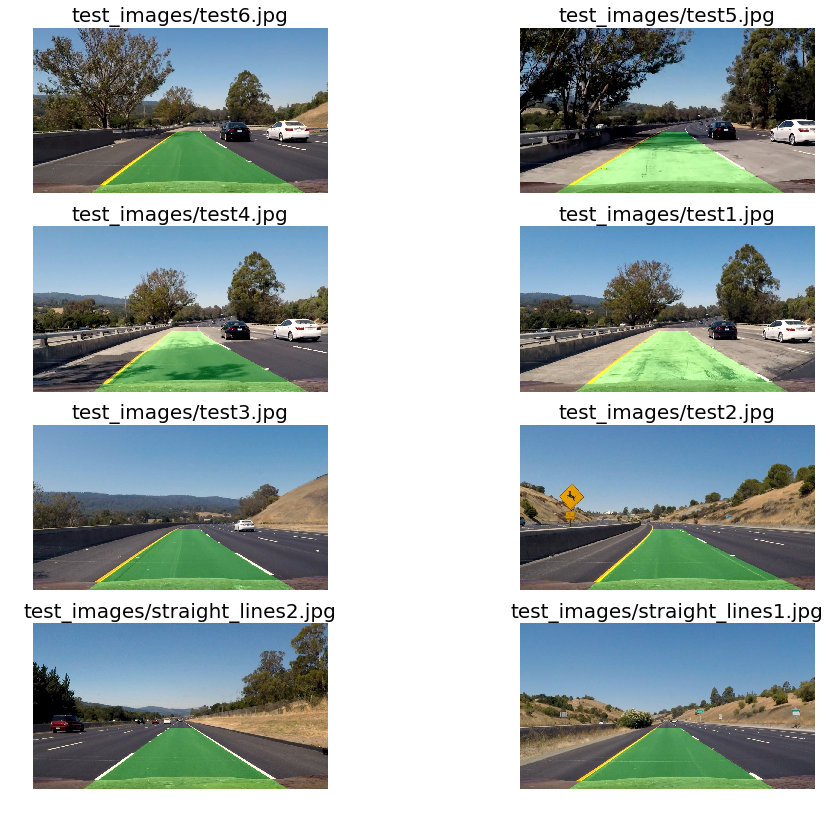

In [38]:
queue = deque( maxlen=10 )

def get_avg_fit():
    left_fitx = np.round( np.mean(np.array(queue)[:,0], axis=0))
    right_fitx = np.round( np.mean(np.array(queue)[:,1], axis=0))
    ploty = np.round( np.mean(np.array(queue)[:,2], axis=0))
    return left_fitx, right_fitx, ploty

def process_image(img):
    warped_img = img_proc_pipeline(img)
    
    window_centroids = find_window_centroids(warped_img, window_width, window_height, margin)
    
    _, _, left_fitx, right_fitx, ploty = find_lines(warped_img, window_centroids)
    
    if left_fitx is None and len(queue) == 0:
        return img
    
    if left_fitx is not None:
        queue.append((left_fitx, right_fitx, ploty))
    
    left_fitx, right_fitx, ploty = get_avg_fit()
    
    unwarp_img = unwarp(img, warped, ploty,  left_fitx,  right_fitx)
    
    return unwarp_img


f, ax = plt.subplots(4, 2, figsize=(16, 14))

for ix in range(4):
    for iy in range(2):
        file_name = test_imgs[ix*2 + iy]
        plt_img(ix,iy, ax, file_name , process_image(mpimg.imread(file_name)))
        queue.clear()

plt.show()


# Videos

In [42]:
from collections import deque

def process_video(video, video_output):
    """ Process frames of video using the process image function to draw lane lines"""
    queue.clear()
    clip1 = VideoFileClip(video)
    clip = clip1.fl_image(process_image)
    clip.write_videofile(video_output, audio=False, verbose=False, progress_bar=False)
    
#process_video("project_video.mp4", 'output_videos/project_video.mp4')
#process_video("project_video.mp4", 'output_videos/project_video.mp4')
#process_video("challenge_video.mp4", 'output_videos/challenge_video.mp4')
process_video("harder_challenge_video.mp4", 'output_videos/harder_challenge_video.mp4')